In [52]:
# Importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from scipy.sparse import hstack



In [53]:
main_df = pd.read_csv('data/train.tsv', sep= '\t')
main_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [54]:
main_df.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')

In [55]:
main_df.shape

(1482535, 8)

In [56]:
main_df.tail()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...
1482534,1482534,Brand new lux de ville wallet,1,Women/Women's Accessories/Wallets,NaN,22.0,0,"New with tag, red with sparkle. Firm price, no..."


In [57]:
main_df['item_condition_id'].unique()

array([3, 1, 2, 4, 5])

In [58]:
#Checking min and max prices to understand what range of prices we can expect for this dataset.

max_price = main_df['price'].max()
min_price = main_df['price'].min()

print(f'Minimum price in the dataset: {min_price}')
print(f'Maximum price in the dataset: {max_price}')

Minimum price in the dataset: 0.0
Maximum price in the dataset: 2009.0


In [59]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [60]:
main_df.duplicated().sum()

0

In [61]:
main_df.isna().sum()


train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          6
dtype: int64

In [62]:
main_df.isna().mean()

train_id             0.000000
name                 0.000000
item_condition_id    0.000000
category_name        0.004268
brand_name           0.426757
price                0.000000
shipping             0.000000
item_description     0.000004
dtype: float64

<Axes: >

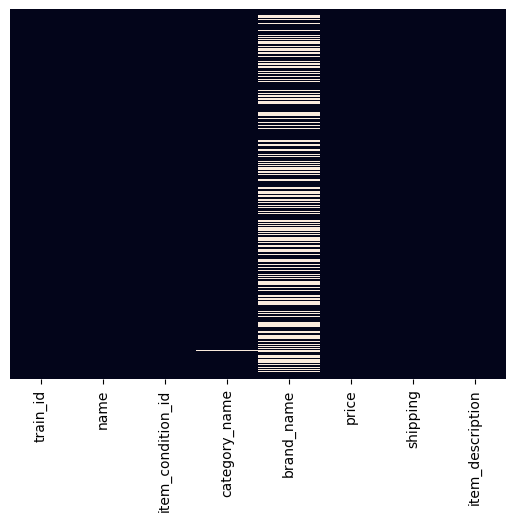

In [63]:
sns.heatmap(main_df.isnull(),
            yticklabels=False,
            cbar=False)

In [64]:
#Dropping Null value rows because the most part is as brand name and we cant make that information up. because we have a vary large amout of rowsin the full dataset we can afford to loose some rows

main_df = main_df.dropna()


In [65]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 846981 entries, 1 to 1482531
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           846981 non-null  int64  
 1   name               846981 non-null  object 
 2   item_condition_id  846981 non-null  int64  
 3   category_name      846981 non-null  object 
 4   brand_name         846981 non-null  object 
 5   price              846981 non-null  float64
 6   shipping           846981 non-null  int64  
 7   item_description   846981 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 58.2+ MB


In [66]:
# Dropping price because it's my y variable and train_id because it doesn't have any meaning for our analysis
plot_columns_distribution = main_df.drop(['train_id', 'name', 'category_name', 'item_description', 'brand_name'], axis=1)

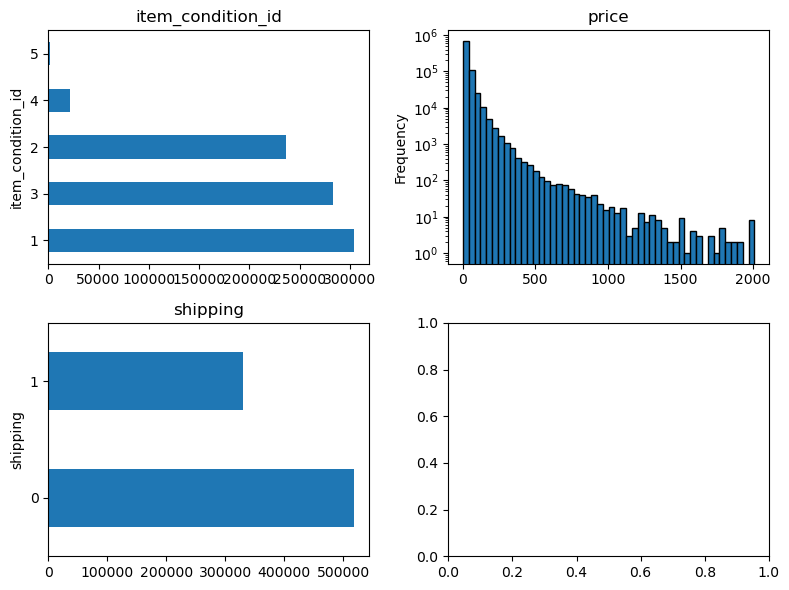

In [67]:
# Write a loop, that goes through all column names, and creates a count plot for each one 
# Specify subplot dimensions 
nrows = 2
ncols = 2

# Create "subplot" grid 
plt.subplots(nrows, ncols, figsize=(8, 6))

# Loop through positions and add plots 
for i, col in enumerate(plot_columns_distribution.columns): 
    plt.subplot(nrows, ncols, i + 1)
    if col == 'price':  # Check if the column is "price"
        main_df[col].plot(kind='hist', bins=50, edgecolor='black', log=True).set_title(col) 
    else:
        main_df[col].value_counts().plot(kind='barh').set_title(col)

plt.tight_layout()
plt.show()


After some EDA, now we will create our tokenizer and pass it into CountVectorizer to get the tokens from the columns: 'name, 'category_name', 'item_description'. After getting cleaned tokens we will apply some techniques from Spacy library before modeling to make sure we have everithing well categorized and clean to start modeling with a linear regression.


In [68]:
# Defining the tokenizer function
forbidden_char = string.punctuation + "1234567890"

def custom_tokenizer(text):
    # Lowercase text
    text = text.lower()

    # Remove special characters
    text = re.sub(f"[{forbidden_char}]", "", text)

    # Split into words as tokens
    tokens = text.split()

    # Filter stopwords
    tokens = [tok for tok in tokens if tok not in ENGLISH_STOP_WORDS and len(tok) > 2]

    return tokens

Now that we created our tokenizer we will create a sample because our next steps will be to tokenize and vectorize the data and that might take too long if we use the whole dataset. So i will create a sample_df that will be used from now on to split our treain and test sets an procede with preprocessing and modeling.

In [69]:
sample_df = main_df.sample(frac=0.05, random_state=42)

In [70]:
sample_df.shape

(42349, 8)

In [71]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42349 entries, 42121 to 201751
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   train_id           42349 non-null  int64  
 1   name               42349 non-null  object 
 2   item_condition_id  42349 non-null  int64  
 3   category_name      42349 non-null  object 
 4   brand_name         42349 non-null  object 
 5   price              42349 non-null  float64
 6   shipping           42349 non-null  int64  
 7   item_description   42349 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 2.9+ MB


In [72]:
#Separating the data into X and y
x = sample_df.drop('price', axis=1)
y = sample_df['price']

In [73]:
# Train test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Here we are extracting from our x_train and x_test the 4 different text columns that we will be passing into our vectorizer separetly. We are doing this process separetly because we need to pass a string list into the vectorizer. also we will vectorize it separatly to make sure we add a prefix to each of the tokens, especifying from which column that tokenizer came from. This will help us having more context when we have our X_train_final.

In [74]:
# x_train text columns separation
x_train_name = x_train['name']

x_train_desc = x_train['item_description']

x_train_brand = x_train['brand_name']

x_train_cat = x_train['category_name']

# x_test text columns separation
x_test_name = x_test['name']

x_test_desc = x_test['item_description']

x_test_brand = x_test['brand_name']

x_test_cat = x_test['category_name']



Below we are vectorizing the text columns separetly(name, desc, brand and category) and then putting them all together with hstack.

In [75]:
# Initialize separate vectorizers for each column
vectorizer_name = CountVectorizer(tokenizer=custom_tokenizer, min_df=10, max_features=1000)
vectorizer_desc = CountVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 2), max_features=2000)
vectorizer_brand = CountVectorizer(tokenizer=custom_tokenizer, min_df=10, max_features=1000)
vectorizer_cat = CountVectorizer(tokenizer=custom_tokenizer, min_df=10, max_features=1000)

# Fit and transform on train data, transform on test data
X_train_name = vectorizer_name.fit_transform(x_train_name)
X_test_name = vectorizer_name.transform(x_test_name)

X_train_desc = vectorizer_desc.fit_transform(x_train_desc)
X_test_desc = vectorizer_desc.transform(x_test_desc)

X_train_brand = vectorizer_brand.fit_transform(x_train_brand)
X_test_brand = vectorizer_brand.transform(x_test_brand)

X_train_cat = vectorizer_cat.fit_transform(x_train_cat)
X_test_cat = vectorizer_cat.transform(x_test_cat)

# Combine all transformed columns into final training and test sets
X_train_text_final = hstack([X_train_name, X_train_desc, X_train_brand, X_train_cat])
X_test_text_final = hstack([X_test_name, X_test_desc, X_test_brand, X_test_cat])


/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Here we are getting feature names out and combining with our tokens also adding a prefix that refers to which column that token came from. After that we convert the whole thing to a dataframe and conbinenames with tokens. then we reset the indexes to make sure we ae ready to merge the text data tokens to the other numerical variables from our full dataset. after merging text data with numerical variables we have our X_train_final and X_test_final ready for modeling.

In [76]:
# Step 1: Get feature names from each vectorizer and add prefixes
feature_names_name = [f"name_{feat}" for feat in vectorizer_name.get_feature_names_out()]
feature_names_desc = [f"desc_{feat}" for feat in vectorizer_desc.get_feature_names_out()]
feature_names_brand = [f"brand_{feat}" for feat in vectorizer_brand.get_feature_names_out()]
feature_names_cat = [f"cat_{feat}" for feat in vectorizer_cat.get_feature_names_out()]

# Combine all feature names
text_feature_names = feature_names_name + feature_names_desc + feature_names_brand + feature_names_cat

# Step 2: Convert sparse matrices to DataFrames
X_train_text_df = pd.DataFrame(X_train_text_final.toarray(), columns=text_feature_names)
X_test_text_df = pd.DataFrame(X_test_text_final.toarray(), columns=text_feature_names)

# Step 3: Reset indices to align with numerical features before merging
X_train_text_df.reset_index(drop=True, inplace=True)
X_test_text_df.reset_index(drop=True, inplace=True)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)

# Step 4: Merge text features back with numerical features
X_train_final = pd.concat([x_train.drop(columns=["name", "item_description", "brand_name", "category_name"]), X_train_text_df], axis=1)
X_test_final = pd.concat([x_test.drop(columns=["name", "item_description", "brand_name", "category_name"]), X_test_text_df], axis=1)


In [77]:
X_train_final

,train_id,item_condition_id,shipping,name_abercrombie,name_abh,name_active,name_adapter,name_adidas,name_advance,name_aeo,...,cat_womenswimwearonepiece,cat_womenswimweartwopiece,cat_womentops,cat_womenunderwearbras,cat_womenunderweargstrings,cat_womenunderwearother,cat_womenunderwearpanties,cat_womenwomens,cat_wraps,cat_zip
0,256649,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1428812,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,355453,2,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,615597,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,413071,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33874,576201,2,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
33875,921430,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33876,859895,3,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
33877,317423,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
